<a href="https://colab.research.google.com/github/PiotMik/CaseWeek/blob/feature%2Fcode/002_Code/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative analysis of yield curve behaviour using Machine Learning

#### Kraków, 12.05.2023
#### Case Week, AGH

# Intro

In this notebook we present a series of practical python exercises i the topic of which will guide you on data loading, data analysis and visualization 


In [51]:
%matplotlib inline 

import numpy as np
from datetime import date
from sklearn.datasets import make_blobs

sns.set()
plt.rcParams['figure.figsize'] = (6, 4)

# Data

Daily data on [UK government bond yields](https://www.bankofengland.co.uk/statistics/yield-curves) are publicly available on the Bank of England website

## Exercise 1: 
1. Download the data archive called "*Daily government liability curve (nominal)*"
2. Open and familiarize with "*GLC Nominal daily data_2016 to present*"
3. Use Excel to prepare a csv dataset
4. Drop to Collab

## Exercise 2:
1. Read the data into python.
2. Display a part of the dataframe
3. Format the index into a proper date index (`pd.Period`)
4. Format the column names into `0.5Y, 1.0Y, ...`


1, 2
https://pandas.pydata.org/docs/getting_started/intro_tutorials/02_read_write.html

3
https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html


###Hints:

In [321]:
# import pandas as pd
# data_path = ...
# rates = pd.read_csv(..., index_col= ...)

# rates.index = pd.to_datetime(..., format = ...).to_period(...)
# rates.columns = [... for n in rates.columns]
# rates.head()

## Exercise 3:
1. What percentage of NaNs are there in each column?
2. Drop the problematic column
3. Drop the rows with NaNs

### Hints:

In [300]:
# rates.isna()
# rates.isna().mean().sort_values()

In [320]:
# rates = rates.drop(... , axis = ...) 
# rates = rates.dropna(how = ...)

## Exercise 4:
1. Plot the 1Y, 5Y, 10Y tenors
2. Plot the yield curve as of the latest available date
3. Add title, axis labels

Optional:
3. Plot the yield curve as of the 5 latest available dates
4. Plot the yield curve as of 5 random dates

### Hints:

In [322]:
# import matplotlib.pyplot as plt
# rates[...].plot()
# plt.xlabel(...)
# plt.ylabel(...)
# plt.title(...)

# Principal Component Analysis



## Exercise 5
1. Compute the correlation matrix of the rates
2. Visualize a heatmap of the correlations

### Hints:

In [325]:
# import seaborn as sns

# corr_matrix = rates.corr()
# sns.heatmap(...)

## Exercise 6
1. Build a `sklearn` pipeline composed of a scaling step, and a PCA step
2. Fit to the data

### Hints:

In [338]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA 
# from sklearn.pipeline import Pipeline

# model = Pipeline([(..., ...),
#                   (..., ...)])

# model.fit(...)

## Exercise 7
1. Look at the explained variance ratio
2. Visualize the cumulative explained variance ratio (e.g. lineplot)
3. Visualize the explained variance ratio (e.g. barplot)

### Hints:


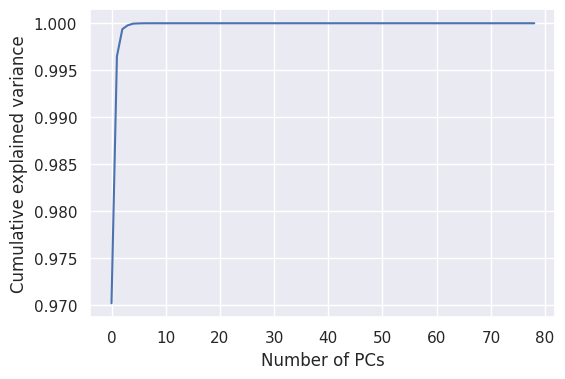

In [331]:
# explained_variance = model[...].explained_variance_ratio_
# plt.plot(explained_variance.cumsum())

## PCA

### Idea


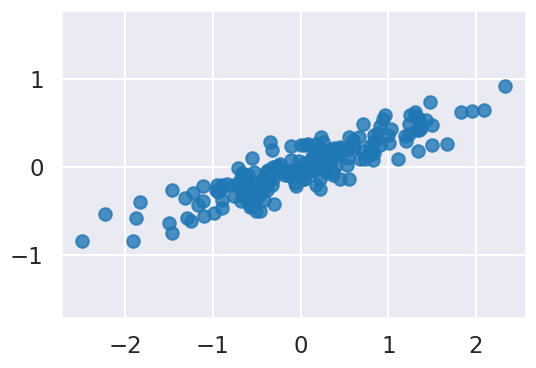

In [ ]:
def draw_vector(v0, v1, col, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color=col)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots()

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.8)
ax.axis('equal');

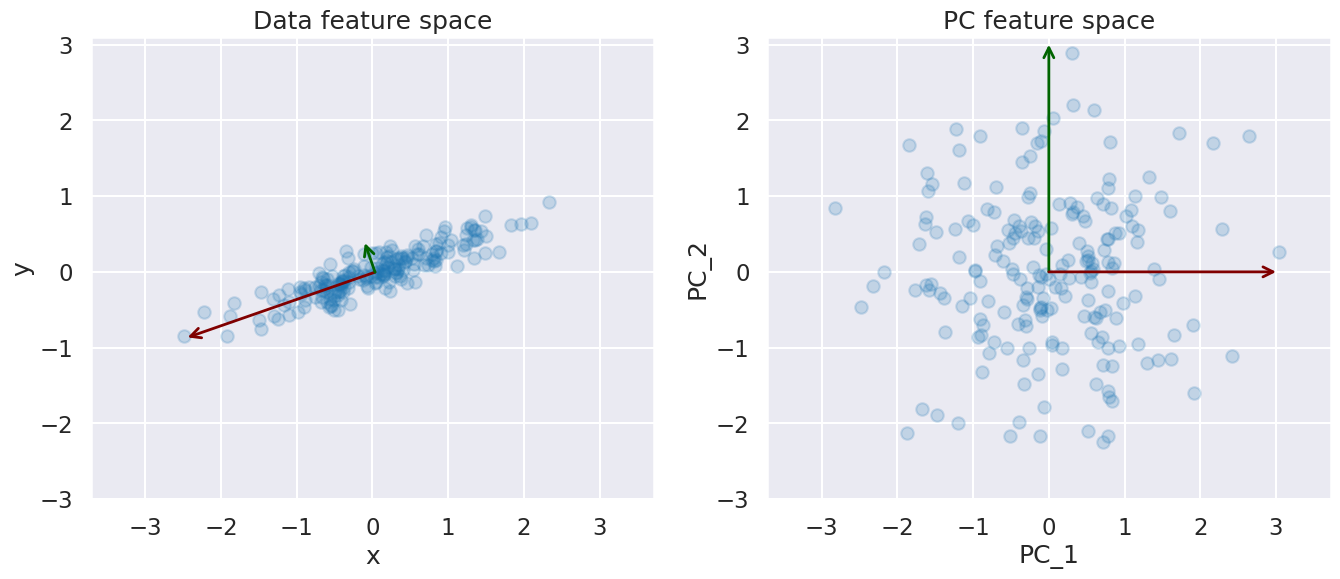

In [ ]:
from seaborn.palettes import color_palette
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector, col in zip(pca.explained_variance_, pca.components_, ['maroon', 'darkgreen']):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0], col=col)
ax[0].axis('equal')
ax[0].set(xlabel='x', ylabel='y',
          title='Data feature space',
          xlim=(-5, 5), ylim=(-3, 3.1))

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1], col='darkgreen')
draw_vector([0, 0], [3, 0], ax=ax[1], col='maroon')
ax[1].axis('equal')
ax[1].set(xlabel='PC_1', ylabel='PC_2',
          title='PC feature space',
          xlim=(-5, 5), ylim=(-3, 3.1));

### Zastosowanie do krzywej OIS

<Axes: >

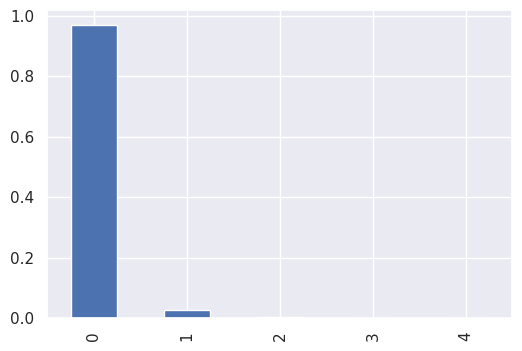

In [195]:
pd.Series(model['pca'].explained_variance_ratio_).head(5).plot(kind = 'bar')

In [197]:
model3 = Pipeline([('scaling', StandardScaler()),
                   ('pca', PCA(n_components=3))])
model3.fit(rates)

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=3))])

In [199]:
data_pca = pd.DataFrame(model3.transform(rates),
                        index = rates.index, columns = ['PC1', 'PC2', 'PC3'])
data_pca

,PC1,PC2,PC3
Date,,,
2016-01-04,7.826956,-2.876095,0.158996
2016-01-05,7.753967,-2.905432,0.171214
2016-01-06,6.993100,-2.878378,0.108346
2016-01-07,7.279514,-3.015897,0.046302
2016-01-08,7.011811,-3.057894,-0.012914
...,...,...,...
2023-04-24,25.586988,1.308957,-1.185335
2023-04-25,24.910797,1.258198,-1.213090
2023-04-26,25.120330,1.167540,-1.190578


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

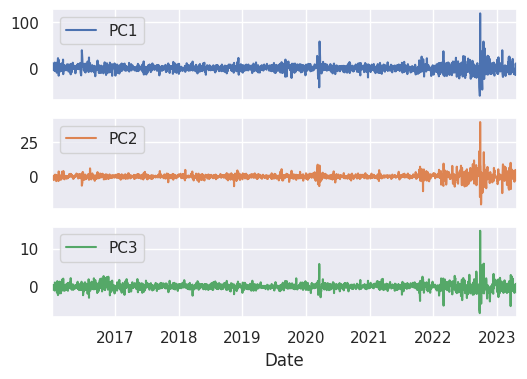

In [66]:
data_pca.plot(subplots=True)

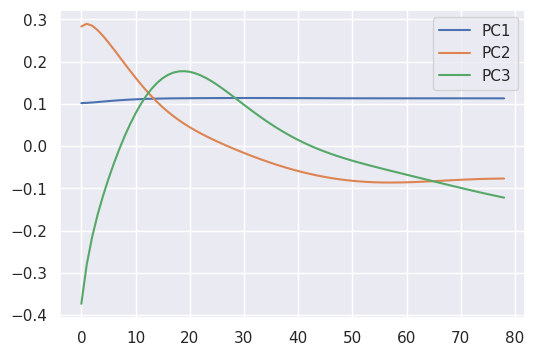

In [200]:
pd.DataFrame(model3['pca'].components_).T.plot(legend = False)
_ = plt.legend(['PC1', 'PC2', 'PC3'])

In [208]:
pca_components = pd.DataFrame(model3['pca'].components_, 
                              index = ['PC1', 'PC2', 'PC3'], 
                              columns = rates.columns)

In [203]:
data_pca.loc['2023-04-28']

PC1    25.435027
PC2     1.189501
PC3    -1.280106
Name: 2023-04-28, dtype: float64

In [212]:
data_pca.shape, pca_components.shape

((1850, 3), (3, 79))

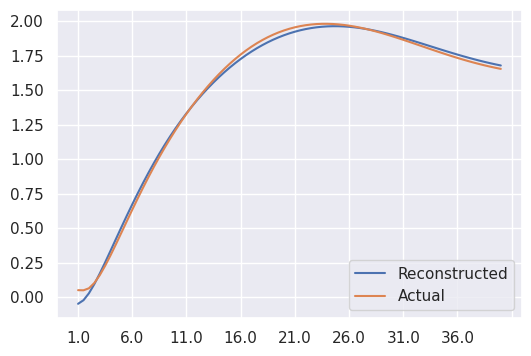

In [240]:
i = 300
pred = (data_pca.iloc[[i], :] @ pca_components)
pred_scaled = pd.DataFrame(model3['scaling'].inverse_transform(pred), 
                           index = pred.index, 
                           columns = pred.columns)

fig, ax = plt.subplots()
pred_scaled.T.plot(ax = ax)
rates.iloc[[i], :].T.plot(ax = ax)
ax.legend(['Reconstructed', 'Actual'])

## Classification

In [274]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

clf = Pipeline([('scaling', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('classifier', IsolationForest(contamination = 0.01, 
                                               random_state=2023))])
clf.fit(rates)

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=2)),
                ('classifier',
                 IsolationForest(contamination=0.01, random_state=2023))])

In [277]:
sc = Pipeline([('scaling', StandardScaler()), 
               ('pca', PCA(n_components=2))])
pre_clf = pd.DataFrame(sc.fit_transform(rates), index=diffs.index, columns = ['PC1', 'PC2'])
pre_clf['Outlier'] = clf.fit_predict(rates) == -1

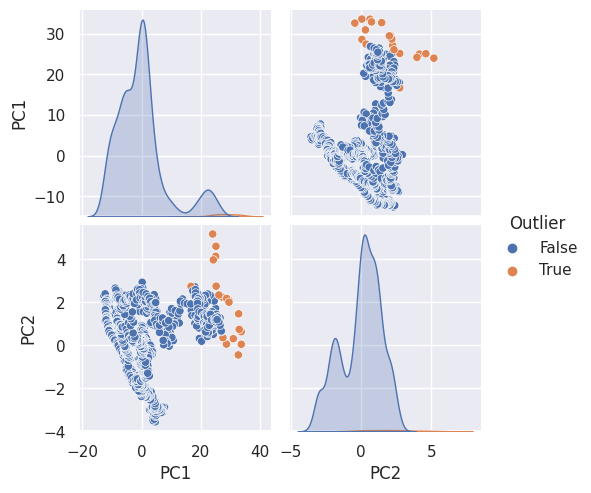

In [278]:
%matplotlib inline 
sns.pairplot(data = pre_clf, hue='Outlier')

In [279]:
outlier_dates = pre_clf[pre_clf['Outlier']].index

<Axes: >

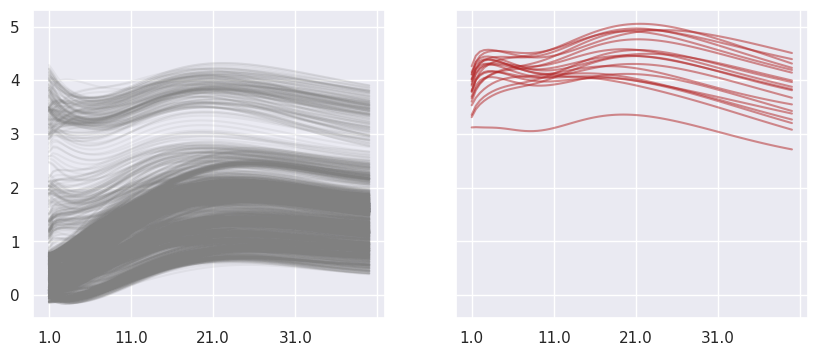

In [288]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
rates.drop(outlier_dates, axis = 0).T.plot(ax = ax[0], legend=False, color = 'grey', alpha = 0.1)
rates.loc[outlier_dates].T.plot(ax = ax[1], legend=False, color = 'firebrick', alpha = 0.5)


# Solutions
---



In [302]:
import pandas as pd
data_path = "/content/uk_govie_spots.csv"
rates = pd.read_csv(data_path, index_col= 0)

rates.index = pd.to_datetime(rates.index, format = "%d/%m/%Y").to_period('D')
rates.columns = [f"{n}Y" for n in rates.columns]
rates.head()

,0.5Y,1.0Y,1.5Y,2.0Y,2.5Y,3.0Y,3.5Y,4.0Y,4.5Y,5.0Y,...,35.5Y,36.0Y,36.5Y,37.0Y,37.5Y,38.0Y,38.5Y,39.0Y,39.5Y,40.0Y
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,0.343417,0.469762,0.611093,0.750127,0.879897,0.998858,1.107422,1.206596,1.297485,...,2.551816,2.540093,2.528709,2.517713,2.507147,2.497049,2.487450,2.478377,2.469853,2.461895
2016-01-05,NaN,0.326072,0.452016,0.593339,0.732392,0.862314,0.981657,1.090866,1.190934,1.282928,...,2.547222,2.535446,2.524007,2.512953,2.502328,2.492170,2.482511,2.473379,2.464796,2.456780
2016-01-06,NaN,0.293395,0.401197,0.534982,0.670284,0.797753,0.915034,1.022254,1.120310,1.210266,...,2.479657,2.467708,2.456107,2.444901,2.434137,2.423852,2.414078,2.404845,2.396174,2.388084
2016-01-07,NaN,0.306486,0.411970,0.540998,0.672406,0.797378,0.913423,1.020404,1.118953,1.209917,...,2.519596,2.507792,2.496322,2.485236,2.474578,2.464386,2.454692,2.445526,2.436909,2.428860
2016-01-08,NaN,0.305554,0.398851,0.518128,0.642686,0.763028,0.876001,0.980996,1.078318,1.168597,...,2.500580,2.488660,2.477077,2.465879,2.455112,2.444813,2.435017,2.425751,2.417038,2.408896


In [305]:
rates.isna().mean().sort_values()

20.0Y    0.031414
29.0Y    0.031414
28.5Y    0.031414
28.0Y    0.031414
27.5Y    0.031414
           ...   
12.0Y    0.031414
11.5Y    0.031414
11.0Y    0.031414
39.5Y    0.031414
0.5Y     0.405759
Length: 80, dtype: float64

In [306]:
rates = rates.drop(['0.5Y'], axis = 1).dropna()

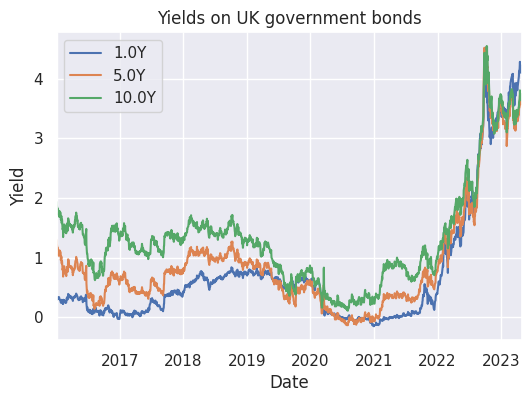

In [319]:
import matplotlib.pyplot as plt

rates[['1.0Y', '5.0Y', '10.0Y']].plot()
_ = plt.xlabel('Date'), plt.ylabel('Yield'), plt.title("Yields on UK government bonds")

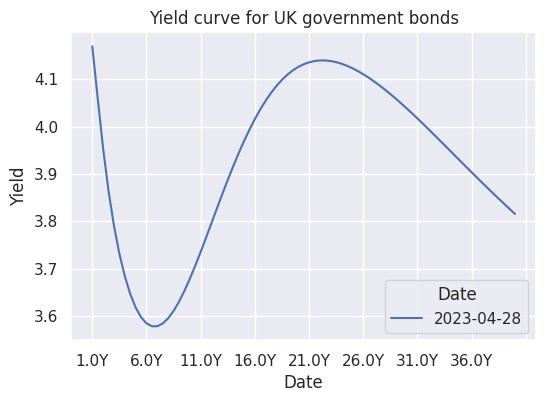

In [317]:
rates.tail(1).T.plot()
_ = plt.xlabel('Date'), plt.ylabel('Yield'), plt.title("Yield curve for UK government bonds")

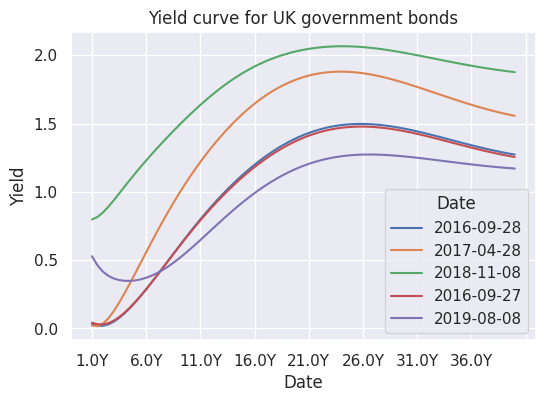

In [318]:
rates.sample(5).T.plot()
_ = plt.xlabel('Date'), plt.ylabel('Yield'), plt.title("Yield curve for UK government bonds")

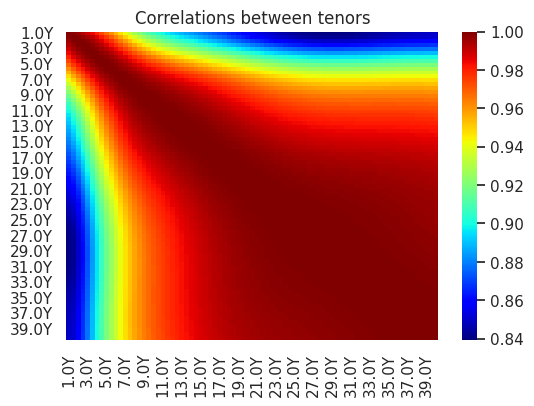

In [333]:
import seaborn as sns
sns.heatmap(rates.corr(), cmap='jet')
_ = plt.title('Correlations between tenors')

In [334]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

model = Pipeline([('scaling', StandardScaler()),
                  ('pca', PCA())])

model.fit(rates)

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA())])

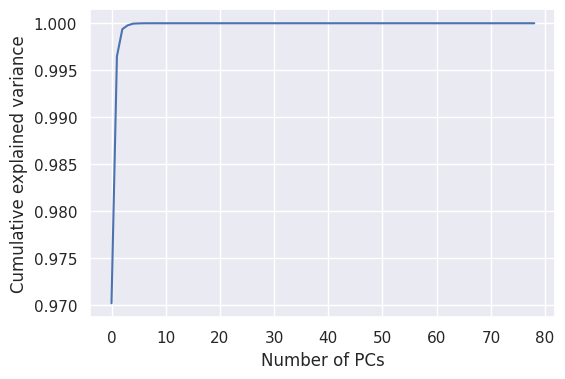

In [335]:
plt.plot(model['pca'].explained_variance_ratio_.cumsum())
_ = plt.ylabel('Cumulative explained variance'), plt.xlabel('Number of PCs')